# Creating a CF-1.6 timeSeries using pocean


We will create [CF-1.6 compliant](http://cfconventions.org/latest.html) file that follows the [Discrete Sampling Geometries](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/build/ch09.html) (DSG) of a `timeSeries` from a pandas DataFrame.

The `pocean` module can handle all the DSGs described in the CF-1.6 document: `point`, `timeSeries`, `trajectory`, `profile`, `timeSeriesProfile`, and `trajectoryProfile`. These DSGs array may be represented in the netCDF file as:

- **orthogonal multidimensional**: when the coordinates along the element axis of the features are identical;
- **incomplete multidimensional**: when the features within a collection do not all have the same number but space is not an issue and using longest feature to all features is convenient;
- **contiguous ragged**: can be used if the size of each feature is known;
- **indexed ragged**: stores the features interleaved along the sample dimension in the data variable.

Here we will use the orthogonal multidimensional array to represent time-series data from am hypothetical current meter. We'll use fake data for this example for convenience.

Our fake data represents a current meter located at 10 meters depth collected last week.

In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd


x = np.arange(100, 110, 0.1)
start = datetime.now() - timedelta(days=7)

df = pd.DataFrame({
    't': [start + timedelta(days=n) for n in range(len(x))],
    'x': -48.6256,
    'y': -27.5717,
    'z': 10,
    'u': np.sin(x),
    'v': np.cos(x),
    'station': 'fake buoy',
})


df.tail()

,station,t,u,v,x,y,z
95,fake buoy,2018-05-22 15:31:10.101983,0.440129,-0.897934,-48.6256,-27.5717,10
96,fake buoy,2018-05-23 15:31:10.101983,0.348287,-0.937388,-48.6256,-27.5717,10
97,fake buoy,2018-05-24 15:31:10.101983,0.252964,-0.967476,-48.6256,-27.5717,10
98,fake buoy,2018-05-25 15:31:10.101983,0.155114,-0.987897,-48.6256,-27.5717,10
99,fake buoy,2018-05-26 15:31:10.101983,0.055714,-0.998447,-48.6256,-27.5717,10


Let's take a look at our fake data.

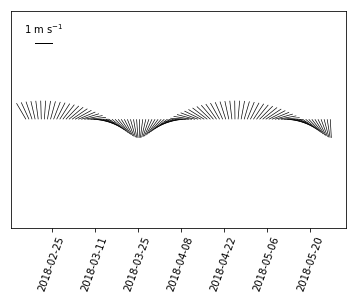

In [2]:
%matplotlib inline


import matplotlib.pyplot as plt
from oceans.plotting import stick_plot

q = stick_plot(
    [t.to_pydatetime() for t in df['t']],
    df['u'],
    df['v']
)

ref = 1
qk = plt.quiverkey(q, 0.1, 0.85, ref,
                  "%s m s$^{-1}$" % ref,
                  labelpos='N', coordinates='axes')

_ = plt.xticks(rotation=70)

`pocean.dsg` is relatively simple to use. The user must provide a DataFrame, like the one above, and a dictionary of attributes that maps to the data and adhere to the DSG conventions desired. 

Because we want the file to work seamlessly with ERDDAP we also added some ERDDAP specific attributes like `cdm_timeseries_variables`, and `subsetVariables`.

In [3]:
attributes = {
    'global': {
        'title': 'Fake mooring',
        'summary': 'Vector current meter ADCP @ 10 m',
        'institution': 'Restaurant at the end of the universe',
        'cdm_timeseries_variables': 'station',
        'subsetVariables': 'depth',
    },
    'longitude': {
        'units': 'degrees_east',
        'standard_name': 'longitude',
    },
    'latitude': {
        'units': 'degrees_north',
        'standard_name': 'latitude',
    },
    'z': {
        'units': 'm',
        'standard_name': 'depth',
        'positive': 'down',
    },
    'u': {
        'units': 'm/s',
        'standard_name': 'eastward_sea_water_velocity',
    },
    'v': {
        'units': 'm/s',
        'standard_name': 'northward_sea_water_velocity',
    },
    'station': {
        'cf_role': 'timeseries_id'
    },
}

In [4]:
from pocean.dsg.timeseries.om import OrthogonalMultidimensionalTimeseries


dsg = OrthogonalMultidimensionalTimeseries.from_dataframe(
    df,
    output='fake_buoy.nc',
    attributes=attributes
)

The `OrthogonalMultidimensionalTimeseries` saves the DataFrame into a CF-1.6 TimeSeries DSG.

In [5]:
!ncdump -h fake_buoy.nc

netcdf fake_buoy {
dimensions:
	t = 100 ;
	station = 1 ;
variables:
	int crs ;
	string station(station) ;
		station:cf_role = "timeseries_id" ;
		station:long_name = "station identifier" ;
	double t(t) ;
		t:units = "seconds since 1990-01-01 00:00:00Z" ;
		t:standard_name = "time" ;
		t:axis = "T" ;
	double y(station) ;
		y:axis = "Y" ;
	double x(station) ;
		x:axis = "X" ;
	int64 z(station) ;
		z:_FillValue = -9999LL ;
		z:axis = "Z" ;
		z:units = "m" ;
		z:standard_name = "depth" ;
		z:positive = "down" ;
	double u(station, t) ;
		u:_FillValue = -9999.9 ;
		u:units = "m/s" ;
		u:standard_name = "eastward_sea_water_velocity" ;
		u:coordinates = "t z x y" ;
	double v(station, t) ;
		v:_FillValue = -9999.9 ;
		v:units = "m/s" ;
		v:standard_name = "northward_sea_water_velocity" ;
		v:coordinates = "t z x y" ;

// global attributes:
		:Conventions = "CF-1.6" ;
		:date_created = "2018-02-23T18:31:00Z" ;
		:featureType = "timeseries" ;
		:cdm_data_type = "Timeseries" ;
		:title = "Fake moo

 It also outputs the dsg object for inspection. Let us check a few things to see if our objects was created as expected. (Note that some of the metadata was "free" due t the built-in defaults in `pocean`.

In [6]:
dsg.getncattr('featureType')

'timeseries'

In [7]:
type(dsg)

pocean.dsg.timeseries.om.OrthogonalMultidimensionalTimeseries

Different from the standard `netCDF4-python` object, `pocean`'s DSGs split the variables in `data_vars`, `ancillary_vars`, and the DSG axes.

In [8]:
[(v.standard_name) for v in dsg.data_vars()]

['eastward_sea_water_velocity', 'northward_sea_water_velocity']

In [9]:
dsg.axes('T')

[<class 'netCDF4._netCDF4.Variable'>
 float64 t(t)
     units: seconds since 1990-01-01 00:00:00Z
     standard_name: time
     axis: T
 unlimited dimensions: 
 current shape = (100,)
 filling on, default _FillValue of 9.969209968386869e+36 used]

In [10]:
dsg.axes('Z')

[<class 'netCDF4._netCDF4.Variable'>
 int64 z(station)
     _FillValue: -9999
     axis: Z
     units: m
     standard_name: depth
     positive: down
 unlimited dimensions: 
 current shape = (1,)
 filling on]

In [11]:
dsg.vatts('station')

{'cf_role': 'timeseries_id', 'long_name': 'station identifier'}

In [12]:
dsg['station'][:]

array(['fake buoy'], dtype=object)

In [13]:
dsg.vatts('u')

{'_FillValue': -9999.9,
 'coordinates': 't z x y',
 'standard_name': 'eastward_sea_water_velocity',
 'units': 'm/s'}

We can easily round-trip back to the pandas DataFrame object.

In [14]:
dsg.to_dataframe().head()

,t,x,y,z,station,u,v
0,2018-02-16 15:31:10.101983,-48.6256,-27.5717,10,fake buoy,-0.506366,0.862319
1,2018-02-17 15:31:10.101983,-48.6256,-27.5717,10,fake buoy,-0.417748,0.908563
2,2018-02-18 15:31:10.101983,-48.6256,-27.5717,10,fake buoy,-0.324956,0.945729
3,2018-02-19 15:31:10.101983,-48.6256,-27.5717,10,fake buoy,-0.228917,0.973446
4,2018-02-20 15:31:10.101983,-48.6256,-27.5717,10,fake buoy,-0.130591,0.991436


For more information on `pocean` please check the [API docs](https://pyoceans.github.io/pocean-core/docs/api/pocean.html).